In [ ]:
#Fake News Calssifier using LSTM

In [ ]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/train.csv')

In [ ]:
data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [ ]:
data.shape

(20800, 5)

In [ ]:
#Drop the null values
data.dropna(inplace = True)

In [ ]:
#Resetting index after dropping null values
data.reset_index(inplace= True)

In [ ]:
#Dropping the extra column which was created after using reset_index()
data = data.drop('index', axis = 1)
data.head(10)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
6,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
7,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0
8,10,Obama’s Organizing for Action Partners with So...,Aaron Klein,"Organizing for Action, the activist group that...",0
9,11,"BBC Comedy Sketch ""Real Housewives of ISIS"" Ca...",Chris Tomlinson,The BBC produced spoof on the “Real Housewives...,0


In [ ]:
#Splitting the data into featuers and labels

X = data.drop('label', axis = 1)
y = data['label']

In [ ]:
X.shape, y.shape

((18285, 4), (18285,))

In [ ]:
#Creating a copy of features to perform operations
message = X.copy()
message.shape

(18285, 4)

In [ ]:
#Import stopwords and wordnet

import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Data Preprocessing.
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
corpus = []

pattern = re.compile('[^a-zA-Z]')
stop_words = set(stopwords.words('english'))

message['processed_title'] = message['title'].apply(lambda x: pattern.sub(' ', x))  # Applying regex substitution to remove non-alphabetic characters
message['processed_title'] = message['processed_title'].str.lower()  # Converting text to lowercase
message['processed_title'] = message['processed_title'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split() if word not in stop_words]))  # Tokenize, remove stopwords, and apply lemmetization.

corpus = message['processed_title'].tolist()  # Converting 'processed_title' column to list
corpus

['house dem aide even see comey letter jason chaffetz tweeted',
 'flynn hillary clinton big woman campus breitbart',
 'truth might get fired',
 'civilian killed single u airstrike identified',
 'iranian woman jailed fictional unpublished story woman stoned death adultery',
 'jackie mason hollywood would love trump bombed north korea lack trans bathroom exclusive video breitbart',
 'beno hamon win french socialist party presidential nomination new york time',
 'back channel plan ukraine russia courtesy trump associate new york time',
 'obama organizing action partner soros linked indivisible disrupt trump agenda',
 'bbc comedy sketch real housewife isi cause outrage',
 'russian researcher discover secret nazi military base treasure hunter arctic photo',
 'u official see link trump russia',
 'yes paid government troll social medium blog forum website',
 'major league soccer argentine find home success new york time',
 'well fargo chief abruptly step new york time',
 'anonymous donor pay 

In [ ]:
#Importing Pytorch
import torch
import torch.nn.functional as F

In [ ]:
#Converting the strings in corpus into integers using dictionary. The size of vocabulary is considered to be 10000 words.
word_to_int = {}
index = 0
voc_size = 10001

for sentence in corpus:
  for word in sentence.split():
    #Once the index goes from 0 to 9999 it means we have 10000 unique words. After that index is not incremented and all other words are given same index i.e voc_size - 1 
    if index >= voc_size - 1:
      if word not in word_to_int:
        word_to_int[word] = index
    else:
        if word not in word_to_int:
          word_to_int[word] = index
          index += 1


message['word_int'] = message['processed_title'].apply(lambda x: [word_to_int[word] for word in x.split()])
corpus_int = message['word_int'].tolist()

In [ ]:
#Check whether the corpus and corpus_int have same size
corpus[7], corpus[6], corpus[11]

('back channel plan ukraine russia courtesy trump associate new york time',
 'beno hamon win french socialist party presidential nomination new york time',
 'u official see link trump russia')

In [ ]:
corpus_int[7], corpus_int[6], corpus_int[11]

([60, 61, 62, 63, 64, 65, 40, 66, 57, 58, 59],
 [49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
 [24, 95, 4, 96, 40, 64])

In [ ]:
#Now do the padding in list of integers in corpus_int to make them of equal sizes.

from torch.nn.utils.rnn import pad_sequence
flipped_sequences = [torch.flip(torch.tensor(sentences_int), dims=[0]) for sentences_int in corpus_int]
padded_sequences = pad_sequence(flipped_sequences, batch_first= True)
sequences = [torch.flip(seq, dims= [0]) for seq in padded_sequences]

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
X_final = np.array(sequences)
y_final = np.array(y).reshape(-1, 1)

#Split the data into train, dev/validation and test set.
X_train, X_dev1, y_train, y_dev1 = train_test_split(X_final, y_final, test_size = 0.20, random_state = 42)

In [ ]:
X_train.shape, X_dev1.shape

((14628, 47), (3657, 47))

In [ ]:
X_dev, X_test, y_dev, y_test = train_test_split(X_dev1, y_dev1, test_size = 0.50, random_state = 42)

In [ ]:
X_dev.shape, y_dev.shape

((1828, 47), (1828, 1))

In [ ]:
#Make the numpy array as tensors
y_train_tensor = torch.tensor(y_train, dtype = torch.float32)
X_train_tensor = torch.tensor(X_train, dtype = torch.int32)

In [ ]:
y_train_tensor[0]

tensor([0.])

In [ ]:
y_dev_tensor = torch.tensor(y_dev, dtype = torch.float32)
X_dev_tensor = torch.tensor(X_dev, dtype = torch.int32)

In [ ]:
y_test_tensor = torch.tensor(y_test, dtype = torch.float32)
X_test_tensor = torch.tensor(X_test, dtype = torch.int32)

In [ ]:
#LSTM Model
import torch.nn as nn
import torch.optim as optim

embedding_dim = 100
hidden_dim = 100

class LSTMModel(nn.Module):
    def __init__(self, voc_size, embedding_dim, hidden_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(voc_size, embedding_dim, padding_idx = voc_size - 1)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, _ = self.lstm(embeds)
        lstm_out = lstm_out[:, -1, :]  # Take the last output of the LSTM
        out = self.fc(lstm_out)
        out = self.sigmoid(out)
        return out


model = LSTMModel(voc_size, embedding_dim, hidden_dim)

# Define loss function and optimizer. We are using Binary Cross Entropy Loss and Adam optimizer.
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())


In [ ]:
train_loss = []
validation_loss = []

#Train the model
for epochs in range(20):
  #Forward Pass
  outputs = model(X_train_tensor)
  loss = criterion(outputs, y_train_tensor)
  train_loss.append(loss.item())
  print(f'Loss: {loss.item()}')

  # Backward pass and optimization
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  #Check loss on validation set
  with torch.no_grad():
    output = model(X_dev_tensor)
    dev_loss = criterion(output, y_dev_tensor)
    validation_loss.append(dev_loss.item())

Loss: 0.7088180184364319
Loss: 0.6815974712371826
Loss: 0.6577892303466797
Loss: 0.6368773579597473
Loss: 0.618479311466217
Loss: 0.6022343635559082
Loss: 0.5876924395561218
Loss: 0.5743255615234375
Loss: 0.5616174936294556
Loss: 0.5491436719894409
Loss: 0.5366102457046509
Loss: 0.5238516330718994
Loss: 0.5108051896095276
Loss: 0.4974808096885681
Loss: 0.48393556475639343
Loss: 0.4702557623386383
Loss: 0.45654603838920593
Loss: 0.4429227113723755
Loss: 0.42950963973999023
Loss: 0.4164329767227173


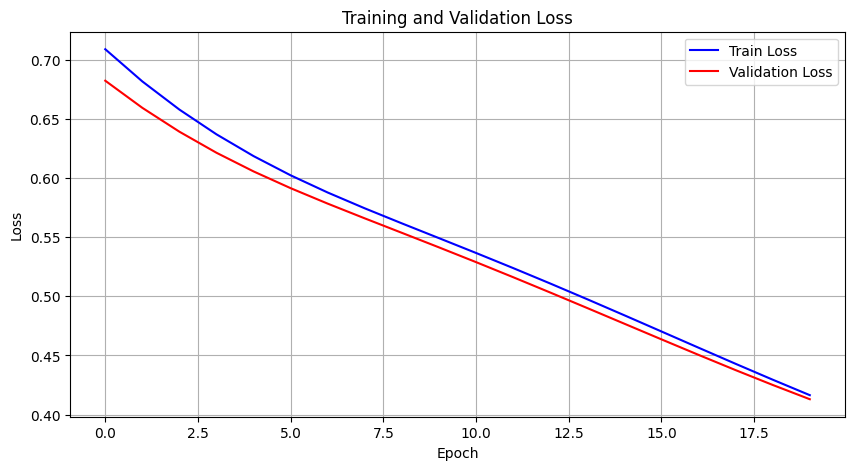

In [ ]:
#Plot the graph between train and validation loss.

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss', color='blue')
plt.plot(validation_loss, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Test the model after training on test set.

#Firstly set the model to evaluation state.
model.eval()

with torch.no_grad():
    test_output = model(X_test_tensor)
    test_loss = criterion(test_output, y_test_tensor)
    print(f'The test loss after 20 epochs is: {test_loss.item()}')

The test loss after 20 epochs is: 0.4095935523509979
